In [1]:
from lake_model_outputspace_exploration import lake_problem

from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
    Policy,
    SequentialEvaluator,
    OutputSpaceExploration
)

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)
lake_model.time_horizon = 100

# specify uncertainties
lake_model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers, one for each time step
lake_model.levers = [
    RealParameter(str(i), 0, 0.1) for i in range(lake_model.time_horizon)
]

# specify outcomes
# TODO kind argument can be ignored when doing
# output space exploration

lake_model.outcomes = [
    ScalarOutcome("max_P", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]

# override some of the defaults of the model
lake_model.constants = [Constant("alpha", 0.41), Constant("nsamples", 150)]

# generate some random policies by sampling over levers
n_scenarios = 1000
reference = Policy('nopolicy', **{l.name:0.02 for l in lake_model.levers})



# outputspace exploration

In [3]:
from ema_workbench.em_framework.optimization import EpsilonProgress

convergence_metrics = [
    EpsilonProgress(),
]

class Wrapper:
    # bit of a hack to get access to the inner state of the algorithm
    def __call__(self, problem, **kwargs):
        self.algorithm = OutputSpaceExploration(problem, **kwargs)
        return self.algorithm
wrapper = Wrapper()

In [4]:

convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    for _ in range(5):
        res, convergence = evaluator.optimize(algorithm=wrapper,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=50000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 convergence=convergence_metrics)
        convergences.append(convergence)
    

[MainProcess/INFO] pool started with 10 workers
53057it [03:26, 256.81it/s]                                                    
[MainProcess/INFO] optimization completed, found 1440 solutions
52496it [03:23, 257.66it/s]                                                    
[MainProcess/INFO] optimization completed, found 1448 solutions
51541it [03:18, 259.04it/s]                                                    
[MainProcess/INFO] optimization completed, found 1459 solutions
54084it [03:22, 266.88it/s]                                                    
[MainProcess/INFO] optimization completed, found 1448 solutions
54469it [03:24, 266.86it/s]                                                    
[MainProcess/INFO] optimization completed, found 1454 solutions
[MainProcess/INFO] terminating pool


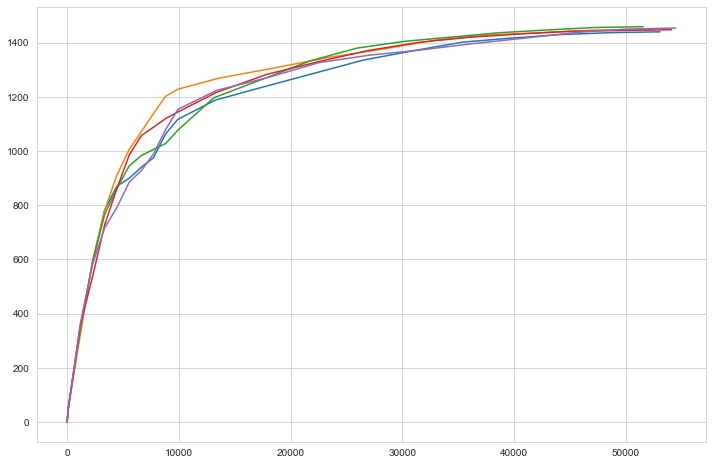

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

In [8]:
from ema_workbench.em_framework.optimization import BORGDefaultDescriptor

from platypus import (GAOperator,
                      DifferentialEvolution,
                      PM)

de_rate = 0.1
de_stepsize = 0.5

pm_p = 1/5
pm_dist = 20


variator = GAOperator(
    DifferentialEvolution(
        crossover_rate=de_rate, step_size=de_stepsize
    ),
    PM(probability=pm_p, distribution_index=pm_dist),
)

convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    for _ in range(5):
        res, convergence = evaluator.optimize(algorithm=wrapper,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=50000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 convergence=convergence_metrics,
                                 variator=variator)
        convergences.append(convergence)

[MainProcess/INFO] pool started with 10 workers
50486it [03:12, 261.69it/s]                                                    
[MainProcess/INFO] optimization completed, found 1473 solutions
51664it [03:16, 263.23it/s]                                                    
[MainProcess/INFO] optimization completed, found 1474 solutions
50610it [03:12, 263.52it/s]                                                    
[MainProcess/INFO] optimization completed, found 1464 solutions
50827it [03:12, 264.27it/s]                                                    
[MainProcess/INFO] optimization completed, found 1475 solutions
51757it [03:21, 257.12it/s]                                                    
[MainProcess/INFO] optimization completed, found 1468 solutions
[MainProcess/INFO] terminating pool


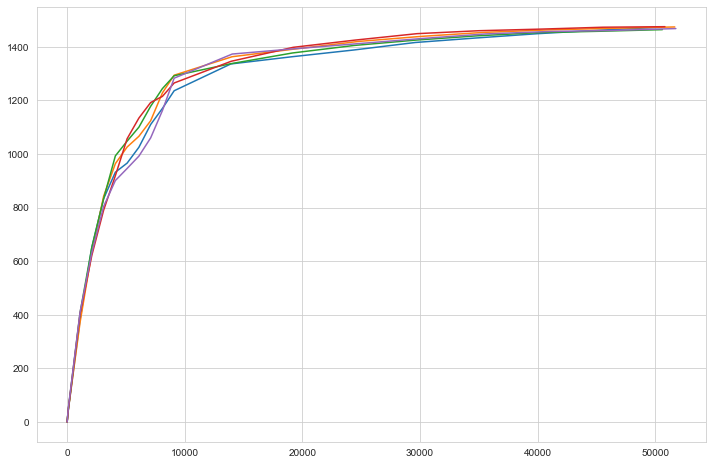

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

# LHS

In [27]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(
                             scenarios=1000,
                             policies=reference)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|█████████████████████████████████████| 1000/1000 [00:03<00:00, 297.62it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# testing hitbox

In [28]:
from ema_workbench.em_framework.output_space_exploration import HitBox

In [29]:
class Solution:
    
    def __init__(self, variables, objectives):
        self.variables = variables
        self.objectives = objectives
        


In [44]:
solutions = [Solution(experiments.iloc[i, :].values, [outcomes['utility'][i],]) for i in range(experiments.shape[0])]

In [45]:
solutions[0].objectives

[0.18001840732581417]

In [55]:
hitbox = HitBox(grid_spec=[(0,1, 0.05)],)
hitbox.extend(solutions)

In [56]:
x = pd.DataFrame([s.objectives for s in hitbox._contents])

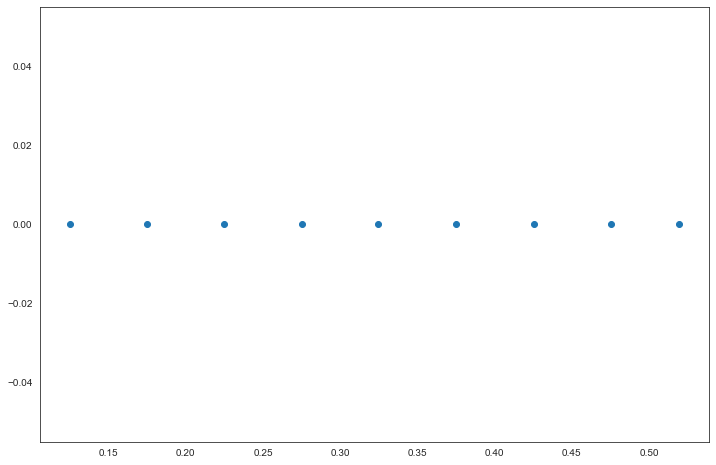

In [57]:
fig, ax = plt.subplots()
ax.scatter(x, np.zeros(x.shape))

# comparison

In [11]:
outcomes = pd.DataFrame(outcomes)
outcomes['sampling'] = 'LHS'

In [12]:
ose = res.iloc[:, 5::].copy()
ose['sampling'] = 'OSE'

In [13]:
data = pd.concat([ose, outcomes], axis=0,ignore_index=True)

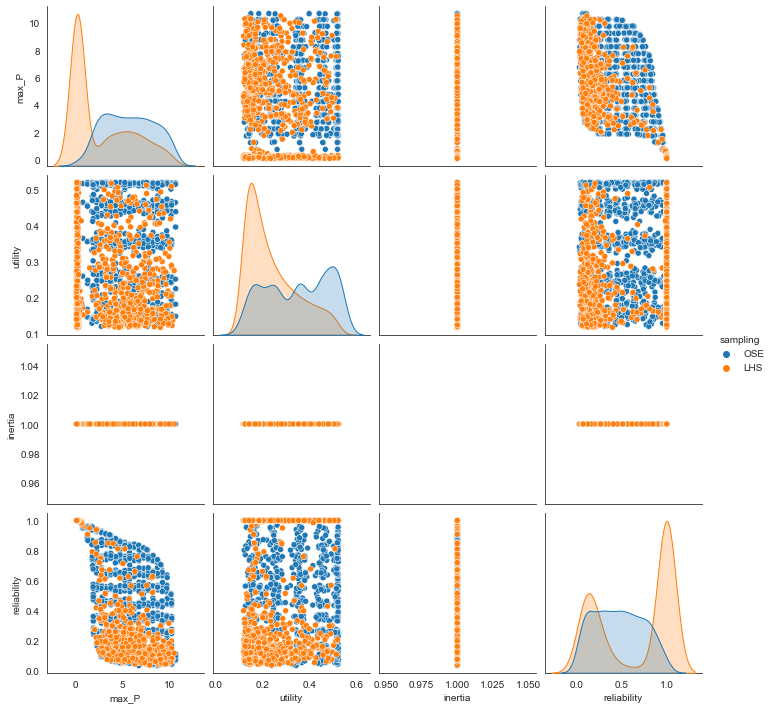

In [14]:
# sns.pairplot(data, hue='sampling')
sns.pairplot(data, hue='sampling', vars=data.columns[0:4])
plt.show()

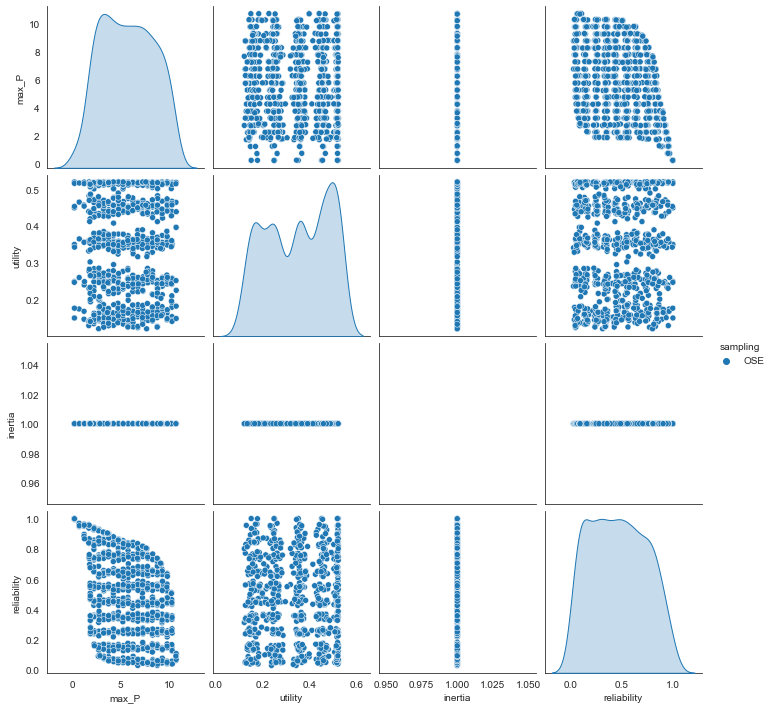

In [15]:
# sns.pairplot(data, hue='sampling')
sns.pairplot(ose, hue='sampling', vars=data.columns[0:4])
plt.show()